In [2]:
# ---------- IMPORTS ----------
import os
import pdfplumber
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

In [3]:


# ---------- CONFIGURATION ----------
VECTOR_STORE_PATH = "faiss_index"
EMBEDDING_MODEL = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
LANGUAGE_MODEL = OllamaLLM(model="deepseek-r1:1.5b")

print(f"Vector Store Path: {VECTOR_STORE_PATH}")
print(f"Embedding Model: {EMBEDDING_MODEL}")
print(f"Language Model: {LANGUAGE_MODEL}")






# ---------- UPLOAD PDF ----------
pdf_folder = "document_store/pdfs"  # Change this path as per your directory structure
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

print(f"PDFs available: {pdf_files}")

if not pdf_files:
    raise FileNotFoundError("No PDFs found in document_store/pdfs")

pdf_path = os.path.join(pdf_folder, pdf_files[0])  # Selecting the first available PDF
print(f"Selected PDF: {pdf_path}")



/var/folders/94/qs5nh6q96jx9hflyqtzr04r00000gn/T/ipykernel_5162/1832493670.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  EMBEDDING_MODEL = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/Users/rashijain/opt/anaconda3/envs/deepseek_agentic_rag_pdf_chatbot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vector Store Path: faiss_index
Embedding Model: client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
) model_name='sentence-transformers/all-MiniLM-L6-v2' cache_folder=None model_kwargs={} encode_kwargs={} multi_process=False show_progress=False
Language Model: OllamaLLM
Params: {}
PDFs available: ['Shivam Negi Resume - AI.pdf']
Selected PDF: document_store/pdfs/Shivam Negi Resume - AI.pdf


In [ ]:

# ---------- LOAD & PROCESS PDF ----------
loader = PDFPlumberLoader(pdf_path)
documents = loader.load()

print("documents : " , documents)
print(f"Loaded {len(documents)} pages from the PDF")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
document_chunks = text_splitter.split_documents(documents)
print(f"Document split into {len(document_chunks)} chunks")

# ---------- CREATE OR LOAD FAISS ----------
if os.path.exists(VECTOR_STORE_PATH):
    vector_store = FAISS.load_local(VECTOR_STORE_PATH, EMBEDDING_MODEL, allow_dangerous_deserialization=True)
    print("Loaded existing FAISS index")
else:
    vector_store = FAISS.load_local(VECTOR_STORE_PATH, EMBEDDING_MODEL, allow_dangerous_deserialization=True)
    vector_store.save_local(VECTOR_STORE_PATH)
    print("Created and saved new FAISS index")

# ---------- QUERY FAISS ----------
query = "What is the main topic of this document?"
print(f"User Query: {query}")

relevant_docs = vector_store.similarity_search(query)
print(f"Found {len(relevant_docs)} relevant document(s)")

# ---------- GENERATE AI RESPONSE ----------
context_text = "\n\n".join([doc.page_content for doc in relevant_docs])
print(f"Context for response:\n{context_text[:500]}...")  # Print only first 500 chars

PROMPT_TEMPLATE = """
You are an expert recruiter. Use the provided context to answer the query. 
If unsure, state that you don't know. Be concise and factual (max 3 sentences).

Query: {user_query} 
Context: {document_context} 
Answer:
"""

conversation_prompt = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
response_chain = conversation_prompt | LANGUAGE_MODEL
response = response_chain.invoke({"user_query": query, "document_context": context_text})

print("AI Response:")
print(response)

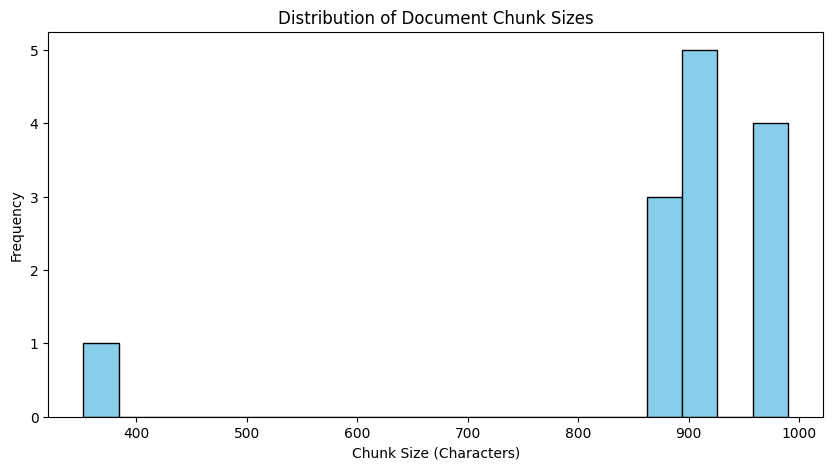

In [27]:
import matplotlib.pyplot as plt

chunk_sizes = [len(doc.page_content) for doc in document_chunks]
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.hist(chunk_sizes, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Chunk Size (Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Document Chunk Sizes")
plt.show()  # Ensure plot is displayed



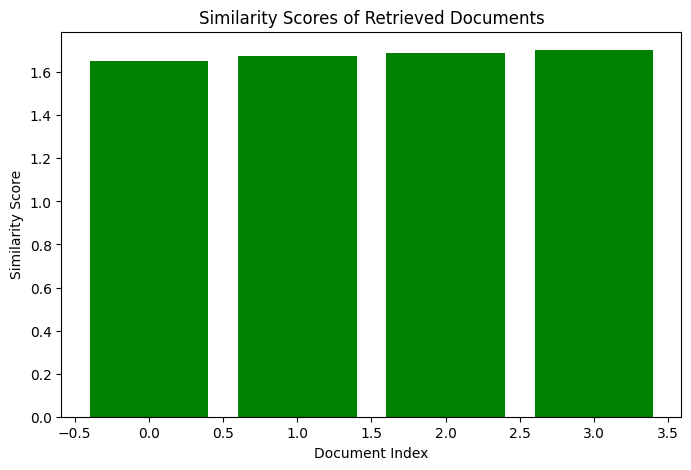

In [28]:
import numpy as np
%matplotlib inline

query_vector = EMBEDDING_MODEL.embed_query(query)
retrieved_docs = vector_store.similarity_search_with_score(query)

similarities = [score for _, score in retrieved_docs]
indices = np.arange(len(similarities))

plt.figure(figsize=(8, 5))
plt.bar(indices, similarities, color='green')
plt.xlabel("Document Index")
plt.ylabel("Similarity Score")
plt.title("Similarity Scores of Retrieved Documents")
plt.show()


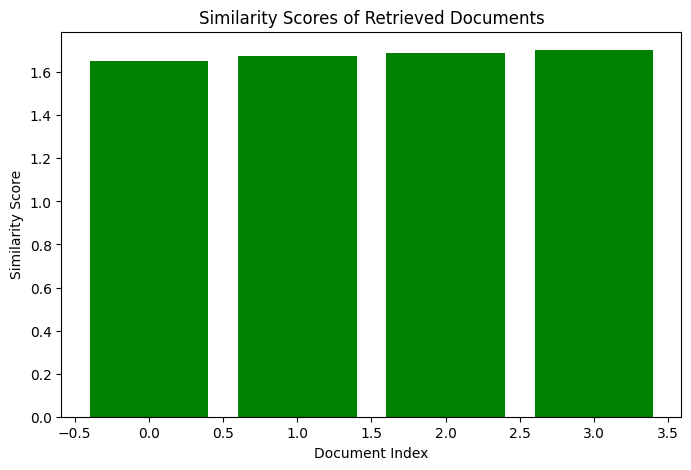

In [29]:
import numpy as np

query_vector = EMBEDDING_MODEL.embed_query(query)
retrieved_docs = vector_store.similarity_search_with_score(query)

similarities = [score for _, score in retrieved_docs]
indices = np.arange(len(similarities))

plt.figure(figsize=(8, 5))
plt.bar(indices, similarities, color='green')
plt.xlabel("Document Index")
plt.ylabel("Similarity Score")
plt.title("Similarity Scores of Retrieved Documents")
plt.show()


In [30]:
from sklearn.manifold import TSNE

# Extract embeddings from FAISS index
faiss_vectors = np.array([vector_store.index.reconstruct(i) for i in range(vector_store.index.ntotal)])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_vectors = tsne.fit_transform(faiss_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5, color='blue')
plt.title("t-SNE Visualization of FAISS Embeddings")
plt.show()


ValueError: perplexity must be less than n_samples